# SP500 Prediction Based on Feature Engineering and RNN(LSTM)

## Feature Engineering


*   This project is the development of a notebook (code + explanation) that successfully engineers 12 unique types of features, **three** for each type of feature engineering: **transforming**, **interacting**, **mapping**, and **extracting**.
* The second part of this project is the development of a **deep learning classification** model to predict the direction of the S&P500 for the dates **2018-01-01—2018-07-12** (test set).



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import talib
import random
import seaborn as sns

Use pytorch to construct nn model because its code is more reusable.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Set random seed to get the same result.

In [3]:
def set_seed(seed_value=42):
    """set the random seed"""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

Preparing the Data

In [4]:
# preparing our data
raw_prices = pd.read_csv("https://storage.googleapis.com/sovai-public/random/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
df = raw_prices.sort_values(by='Dates')
df["target"] = df["SP500"].pct_change().shift(-1)
df["target"] = np.where(df["target"]>0,1,0)
df.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB,target
Dates,,,,,,,,,,,,,,,,,,
1989-02-01,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67,0
1989-02-02,2043.4,878.08,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,101.017,101.905,154.94,117.69,1642.94,135.052,287.03,1
1989-02-03,2069.9,884.09,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,100.921,101.718,155.69,118.62,1659.11,137.134,285.63,0
1989-02-06,2044.3,885.49,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,100.794,101.468,155.58,118.89,1656.86,137.037,284.69,1
1989-02-07,2072.8,883.82,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,101.144,102.092,156.84,118.28,1662.76,136.914,284.21,0


### Train Test Split

In [5]:
from sklearn.model_selection import train_test_split
y = df.pop("target")
X = df.copy()

X_train = X[X.index.astype(str)<'2018-01-01']  # extract data before 2018-01-01 to be training set
y_train = y[X_train.index]  # extract data before 2018-01-01 to be training set
X_test = X[~X.index.isin(X_train.index)]  # extract data after 2018-01-01 to be test set
y_test = y[X_test.index]  # extract data after 2018-01-01 to be test set

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### EDA

There are many types of asset in features. Let's analyze the correlation of all features to explore there relationship.

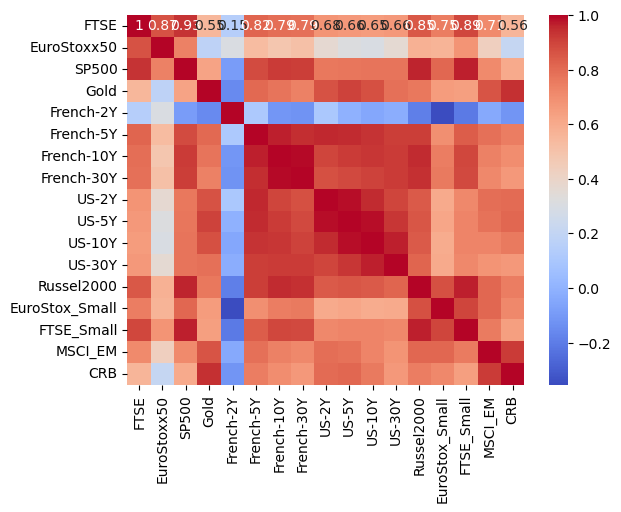

In [6]:
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.show()

It seems that most assets are positively correlated. However, French - 2Y is negatively correlated with other assets. 

### Transforming

1. Refresh your mind on tranformation methods by going back to the material. I am simply providing 1 example here.
1. Don't repeat my logarithmic return calculation, develop your own transformation (there are 1000s of types of transformations).
1. In the example I provide, there is also an error that you have to fix. For example, one of the errors below is that you should actually use `np.log1p()`, but there is another one, so watch out!

#### Logarithmic return:

The error of this example is that the logarithmic return should calculated as log(FTSE_t/FTSE_t-1). In addition, using np.log1p(x) will increase the accuracy of the calculation.

In [7]:
# Example Transforming (has errors)

# Name: Logarithmic return of FTSE
# Description: Developing the logarithmic return feature for use within linear models that make normality assumptions.
# Error: The logarithmic return should calculated as log(FTSE_t/FTSE_t-1). In addition, using np.log1p(x) will increase the accuracy of the calculation.

# df["FTSE_log"] = np.log1p(df['FTSE'] / df['FTSE'].shift(1) - 1)
# df["FTSE_log"]

def get_FTSE_log_return(df):
    df.loc[:,"FTSE_log"] = np.log1p(df['FTSE'] / df['FTSE'].shift(1) - 1)  ## use np.log1p to imcrease the accuracy
    return df

X_train = get_FTSE_log_return(X_train.copy())
X_test = get_FTSE_log_return(X_test.copy())

#### RSI (Relative Strength Index):
The Relative Strength Index is a popular indicator used to forecast the future trend of the market. This indicator measures the relative strength of buying and selling forces in the market. Therefore, it should be an important feature for explaining the moving direction of the price.

In [8]:
## Transforming 1 (Add code below)

# Name: RSI
# Description: see above

from talib import RSI

def get_SP500_RSI(df,N=20):
    df.loc[:,'SP500_RSI'] = RSI(df['SP500'], timeperiod=N)
    return df

X_train = get_SP500_RSI(X_train.copy(),20)
X_test = get_SP500_RSI(X_test.copy(),20)

#### MACD (Moving Average Convergence Divergence)
MACD is a popular indicator to measure the trend in the stock market. MACD consists of three components.
1. MACD Line (Fast Line): The MACD line is typically calculated as the difference between the 12-day Exponential Moving Average (EMA) and the 26-day EMA.
2. Signal Line (Slow Line): The signal line is typically calculated as the 9-day EMA of the MACD line.
3. Histogram: The histogram is calculated as the difference between the MACD line and the Signal line.  

In practice, a crossover of the MACD line above the signal line is often seen as a buy signal, while a crossover below is viewed as a sell signal. The histogram shows the strength of the trend.

In [9]:
## Transforming 2 (Add code below)

# Name: MACD
# Description: see above

from talib import MACD

def get_FTSE_MACD(df,N=20):
    macd, macdsignal, macdhist = MACD(df['FTSE'], fastperiod=12, slowperiod=26, signalperiod=9)
    df.loc[:,'FTSE_MACD'] = macd
    df.loc[:,'FTSE_MACDsignal'] = macdsignal
    df.loc[:,'FTSE_MACDhist'] = macdhist
    return df

X_train = get_FTSE_MACD(X_train.copy(),20)
X_test = get_FTSE_MACD(X_test.copy(),20)

In [10]:
## Transforming 3 (Add code below)

# Name: MOM (Momentum) of SP500
# Description: MOM (Momentum) is an indicator that shows the speed and strength of price changes. 
#              MOM demonstrates the momentum of price by calculating the difference between the current price and the price from a previous period.

from talib import MOM

def get_SP500_MOM(df,N=20):
    df.loc[:,'SP500_MOM'] = MOM(df['SP500'], timeperiod=N)
    return df

X_train = get_SP500_MOM(X_train.copy(),20)
X_test = get_SP500_MOM(X_test.copy(),20)

### Interacting

There are millions of possible interaction methods, be creative and come up with your own. For this assignment there is no 'right' feature engineering method, you simply develop one, and give it a name and a discreption.

The error of this example is that gold return should be calculated as the percentage change of gold price.

In [11]:
# Example Interacting

# Name: Ratio of Gold return to 10Y treasury
# Desciption: Both gold and treasuries are safe-haven assets and descrepency in their ratio could be a sign of some marco-economic event.
# error: Gold return should be calculated as the percentage change of gold price.

def gold_to_yield(df):
    teny_returns = df["US-10Y"].pct_change()
    gold_returns = df["Gold"].pct_change()
    df["gold_r__div__teny_r"] = gold_returns/teny_returns
    return df

X_train = gold_to_yield(X_train)
X_test = gold_to_yield(X_test)

In [12]:
## Interacting 1 (Add code below)

# Name: Ratio of 2Y US treasury return to 30Y US treasury
# Desciption: 2Y treasury and 30Y treasury are risk free asset with different maturity. Their ratio could capture some features of yield curve.

def Short_to_long_US_yield(df):
    long_returns = df["US-30Y"].pct_change()
    short_returns = df["US-2Y"].pct_change()
    df["twoy_r__div__teny_r"] = short_returns/long_returns
    return df

X_train = Short_to_long_US_yield(X_train)
X_test = Short_to_long_US_yield(X_test)

In [13]:
## Interacting 2 (Add code below)

# Name: Ratio of 10Y French treasury return to 10Y US treasury
# Desciption: 10Y French treasury and 10Y US treasury are risk free asset with different currency. Their ratio could capture features of different currency.

def French_to_US_yield(df):
    US_returns = df["US-10Y"].pct_change()
    French_returns = df["French-10Y"].pct_change()
    df["French_r__div__US_r"] = French_returns/US_returns
    return df

X_train = French_to_US_yield(X_train)
X_test = French_to_US_yield(X_test)

In [14]:
## Interacting 3 (Add code below)

# Name: Ratio of SP500 return to CRB
# Desciption: CRB stands for Commodity Research Bureau, which is an important index reflecting the the global dynamics of commodity prices. 
#             It takes a variety of commodities into consideration including energy, metals, and agricultural products.
#             Therefore, it is an essential indicator measuring the performance of the commodity markets. 
#             The ratio of SP500 return to CRB is able to capture the difference and relationship between the stock markets and the commodity markets.

def SP_to_CRB_yield(df):
    CRB_returns = df["CRB"].pct_change()
    SP_returns = df["SP500"].pct_change()
    df["SP_r__div__CRB_r"] = SP_returns/CRB_returns
    return df

X_train = SP_to_CRB_yield(X_train)
X_test = SP_to_CRB_yield(X_test)

### Mapping

This one is slightly harder, you have to identify other  dimensionality reduction methods, there are many more than just PCA. Maybe you can also look at performing the decompositions just on a single asset classes, e.g., US-2Y, US-5Y, US-10Y, US-30Y is a fixed income asset class, but there are a few others in the dataset.

The error of this example is that some features other than assets returns are fed to PCA. We need to select all the assets and calcualte their returns before we feed them to PCA.

In [15]:
# Example Mapping

# Name: First prinicipal component of all of the assets returns
# Description:For stocks the first component resmbles the return of the market, for multiple asset classes it could resemble a 'universal' asset class
# Error: Some features other than assets returns are fed to PCA. We need to select all the assets and calcualte their returns before we feed them to PCA.

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_first(X_train, X_test,assets,column_name):
    # select all the assets
    X_train_assets = X_train.loc[:,assets]
    X_test_assets = X_test.loc[:,assets]

    # calculate returns of all assets
    X_train_returns = X_train_assets.pct_change()
    X_test_returns = X_test_assets.pct_change()

    X_train_imputed = X_train_returns
    X_test_imputed = X_test_returns

    # standarize
    sc = StandardScaler()
    X_train_s = sc.fit_transform(X_train_imputed.fillna(0))
    X_test_s = sc.transform(X_test_imputed.fillna(0))

    # PCA
    pca = PCA(1)
    X_train[column_name] = pca.fit_transform(X_train_s)
    X_test[column_name] = pca.transform(X_test_s)
    return X_train, X_test

assets_all = df.columns
column_name = 'all_assets_PCA1'
X_train, X_test = pca_first(X_train, X_test,assets_all,column_name)

In [16]:
## Mapping 1 (Add code below)

# Name: PCA => First prinicipal component of all of US fixed income asset returns (PCA)
# Description: First principal component of US fixed income asset returns reflects the return of all US fixed income asset with different maturities

assets_US = df.filter(regex='^US-').columns
column_name = 'US_PCA1'
X_train, X_test = pca_first(X_train, X_test,assets_US,column_name)

In [17]:
## Mapping 2 (Add code below)

# Name: Factor analysis => Latent factors of all of French fixed income asset returns (Factor analysis)
# Description: Factor analysis is a type of machine learning technique aiming to describe observable variables using a small number of latent factors. 
#              By interpreting the shared variation of observable variables through their linear combinations, 
#              factor analysis provides meaningful explanations of these variables, thereby reducing the number of variables.
#              In this case, we will find the latent factor of all French fixed income asset returns to capture the feature of the whole French fixed income market.

from sklearn.decomposition import FactorAnalysis

def factor_analysis_first(X_train, X_test,assets,column_name):
    # select all the assets
    X_train_assets = X_train.loc[:,assets]
    X_test_assets = X_test.loc[:,assets]

    # calculate returns of all assets
    X_train_returns = X_train_assets.pct_change()
    X_test_returns = X_test_assets.pct_change()

    # replace the inf value
    X_train_imputed = X_train_returns
    X_test_imputed = X_test_returns

    # standarize
    sc = StandardScaler()
    X_train_s = sc.fit_transform(X_train_imputed.fillna(0))
    X_test_s = sc.transform(X_test_imputed.fillna(0))

    # factor analysis
    factor = FactorAnalysis(n_components=1, random_state=0)
    X_train[column_name] = factor.fit_transform(X_train_s)
    X_test[column_name] = factor.transform(X_test_s)
    return X_train, X_test

assets_French = df.filter(regex='^French-').columns
column_name = 'French_FA1'
X_train, X_test = factor_analysis_first(X_train, X_test,assets_all,column_name)

In [18]:
## Mapping 3 (Add code below)

# Name: Factor analysis => Latent factors of all stock index returns (Factor analysis)
# Description: In this case, we will find two latent factors of all stock index returns to capture the feature of all stock market.

def factor_analysis_two(X_train, X_test,assets,column_name):
    # select all the assets
    X_train_assets = X_train.loc[:,assets]
    X_test_assets = X_test.loc[:,assets]

    # calculate returns of all assets
    X_train_returns = X_train_assets.pct_change()
    X_test_returns = X_test_assets.pct_change()

    # replace the inf value
    X_train_imputed = X_train_returns
    X_test_imputed = X_test_returns

    # standarize
    sc = StandardScaler()
    X_train_s = sc.fit_transform(X_train_imputed.fillna(0))
    X_test_s = sc.transform(X_test_imputed.fillna(0))

    # factor analysis
    factor2 = FactorAnalysis(n_components=2, random_state=0)
    X_train[column_name] = factor2.fit_transform(X_train_s)
    X_test[column_name] = factor2.transform(X_test_s)
    return X_train, X_test

assets_stock = ['FTSE', 'EuroStoxx50', 'SP500','Russel2000', 'EuroStox_Small', 'FTSE_Small', 'MSCI_EM']
column_name = ['Stock_FA1','Stock_FA2']
X_train, X_test = factor_analysis_two(X_train, X_test,assets_stock,column_name)

Extracting

The error of this example is that the rolling window is too large for the test set and it is annualized in a wrong way.

In [19]:
# Example Extracting
# Name: Annualized volatility in returns
# Description: We are developing an annualized volatility measure for all asset returns, which is a good measure of market turbulence
# Error: The rolling window is too large for the test set and it is annualized in a wrong way. 

def vola(df,assets):
  volatility = df.loc[:,assets].pct_change().rolling(window=20).std()*np.sqrt(252)
  new_names = [(i,i+'_vol') for i in assets]
  volatility.rename(columns = dict(new_names), inplace=True)
  df = pd.concat((df, volatility), axis=1)
  return df

assets_all = df.columns
X_train = vola(X_train,assets_all); X_test = vola(X_test,assets_all)

#### Bollinger Bands (BBANDS):  

Bollinger Bands consist of three lines:

1. Middle Band: The middle band a Simple Moving Average (SMA) of prices over a certain period. The window is often set to be 20 days. The middle band is able to describe the main trend of the price.

2. Upper Band: The upper band is calculated by adding twice the standard deviations to the middle band. The upper band relects the potential upper limit of the price.

3. Lower Band: The lowe band is calculated by subtracting twice the standard deviations from the middle band. The lower band relects the potential upper limit of the price.

Bollinger Bands are able to describe the reasonable interval of the price by setting upper bands and lower bands. The relationship between the actual price, the upper bands and the lower bands is an important indicator for determining whether the price is at a high or low level. The distance between the upper and lower bands also reflects the volatility of the price.

In [20]:
## Extracting 1 (Add code below)

# Name: Bollinger Bands of SP500
# Description: see above

from talib import BBANDS

def get_SP500_BBANDS(df,N=20):
    high, mid, low = BBANDS(df['SP500'], timeperiod=N)
    df.loc[:,'SP500_BBANDS_high'] = high
    df.loc[:,'SP500_BBANDS_mid'] = mid
    df.loc[:,'SP500_BBANDS_low'] = low
    return df

X_train = get_SP500_BBANDS(X_train.copy(),20)
X_test = get_SP500_BBANDS(X_test.copy(),20)

In [21]:
## Extracting 2 (Add code below)

# Name: The rolling ratio of the range of price to the mean of price
# Description: This indicator calculates the difference between the highest and lowest prices in a rolling window and then is adjusted by the rolling mean, 
#              which measures the magnitude of price fluctuations over a past period.

def get_FTSE_Rolling_Range(df,N=20):
    price_highest = df['FTSE'].rolling(window=N).max()
    price_lowest = df['FTSE'].rolling(window=N).min()
    df.loc[:,'FTSE_Rolling_Range'] = (price_highest - price_lowest) / df['FTSE'].rolling(window=N).mean()
    return df

X_train = get_FTSE_Rolling_Range(X_train.copy(),20)
X_test = get_FTSE_Rolling_Range(X_test.copy(),20)

In [22]:
## Extracting 3 (Add code below)

# Name: Rolling Max Drawdown Percentage
# Description: This indicator calculate the Max Drawdown over rolling in a rolling window and then is adjusted by the rolling mean,
#              which shows the the risk of price decline over a past period.

def get_SP500_Rolling_MDP(df,N=20):
    df.loc[:,'SP500_Rolling_MDP'] = df['SP500'].rolling(window=N).apply(lambda x: np.max(x.cummax()-x)/np.mean(x))
    return df

X_train = get_SP500_Rolling_MDP(X_train.copy(),20)
X_test = get_SP500_Rolling_MDP(X_test.copy(),20)

## Deep Learning Binary Classification

* For the deep learning model you can perform new data preprocessing methods and new feature engineering that are better suited to neural networks. You can also use all or some of the features you developed above (most features work in deep learning models as long as they are normalized).
* Make sure that you switch your GPU on, you have access to it on Colab. The training stage also takes long, you might want to use a smaller amount of data, or fewer epochs at first to speed up your development process.
* You can report two metrics the ROC(AUC) and the Accuracy against the test set.
* Also remember to set the random seed (random state) so that when others run your software, they get similar results (the results doesn't have to be exactely the same).
* You can also choose other type of deep learning archetecture, e.g., RNN, GRU, CNN.

Choose to use Pytorch because Pytorch code is more reusable.

Environment Settings

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
print('CUDA Version:',torch.version.cuda)
print('PyTorch Version:',torch.__version__)
print('Is the Graphics Card Available:','Available' if(torch.cuda.is_available()) else 'Not Available')
print('Number of Graphics Cards:',torch.cuda.device_count())
print('Current Graphics Card Model:',torch.cuda.get_device_name())
print('Current Graphics Card\'s CUDA Compute Capability:',torch.cuda.get_device_capability())
print('Total Video Memory of Current Graphics Card:',torch.cuda.get_device_properties(0).total_memory/1024/1024/1024,'GB')
print('Does It Support TensorCore:','Supported' if (torch.cuda.get_device_properties(0).major >= 7) else 'Not Supported')
print('Current Graphics Card\'s Video Memory Usage:',torch.cuda.memory_allocated(0)/torch.cuda.get_device_properties(0).total_memory*100,'%')

CUDA Version: 11.8
PyTorch Version: 2.1.0
Is the Graphics Card Available: Available
Number of Graphics Cards: 1
Current Graphics Card Model: NVIDIA GeForce RTX 4060 Laptop GPU
Current Graphics Card's CUDA Compute Capability: (8, 9)
Total Video Memory of Current Graphics Card: 7.99560546875 GB
Does It Support TensorCore: Supported
Current Graphics Card's Video Memory Usage: 0.0 %


Data loading and preprocessing

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class InfToMinMaxTransformer(BaseEstimator, TransformerMixin):
    '''
    Replace -inf with min value and inf with max value for each feature, 
    using rolling calculations for training set and global values for test set to avoid data leakage.
    '''
    def __init__(self, window_size=10):
        self.window_size = window_size
        self.global_max_values_ = None
        self.global_min_values_ = None

    def fit(self, X, y=None):
        # Calculate the global max and min values from the training set
        self.global_max_values_ = X.replace([np.inf, -np.inf], np.nan).max()
        self.global_min_values_ = X.replace([np.inf, -np.inf], np.nan).min()
        return self

    def transform(self, X, y=None, is_train_data=True):
        X_transformed = X.copy()
        if is_train_data:
            # Use rolling calculations for training data
            for col in X_transformed.columns:
                col_data = X_transformed[col].replace([np.inf, -np.inf], np.nan)
                rolling_max = col_data.rolling(window=self.window_size, min_periods=1).max()
                rolling_min = col_data.rolling(window=self.window_size, min_periods=1).min()
                X_transformed[col] = X_transformed[col].combine(rolling_max,min)
                X_transformed[col] = X_transformed[col].combine(rolling_min,max)
        else:
            # Use global max and min values for test data
            for col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].replace(np.inf, self.global_max_values_[col], inplace=False)
                X_transformed[col] = X_transformed[col].replace(-np.inf, self.global_min_values_[col], inplace=False)
        return X_transformed


In [27]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

inf_imputer = InfToMinMaxTransformer()
inf_imputer.fit(X_train)
X_train_imputed = inf_imputer.transform(X_train,is_train_data=True)
X_test_imputed = inf_imputer.transform(X_test,is_train_data=False)

# normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# data preprocessing
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample_x, sample_y = self.X[idx], self.y[idx]
        sample_x = sample_x.unsqueeze(0)  # adjust the dimension to (1, the number of features)
        return sample_x, sample_y

# create dataloader for train set and test set
batch_size = 64
train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test the dataloader
ss = 0
for data, target in train_loader:
    print("Batch X size:", data.shape)
    print("Batch Y size:", target.shape)
    ss = ss+1
    if ss>=3:
        break

Batch X size: torch.Size([64, 1, 54])
Batch Y size: torch.Size([64])
Batch X size: torch.Size([64, 1, 54])
Batch Y size: torch.Size([64])
Batch X size: torch.Size([64, 1, 54])
Batch Y size: torch.Size([64])


In [28]:
X_train_scaled.shape

(7169, 54)

In [29]:
train_dataset.__getitem__(0)[0].shape[1]

54

In [30]:
train_dataset.__getitem__(0)[0].device

device(type='cpu')

build LSTM nn model

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize h0 and c0
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        # forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # only take the last output
        return torch.sigmoid(out)  # use sigmoid fuction to make binary classification

Hyperparameter tunning

In [32]:
# 1. split the train set and validation set in hyperparameter tuning
val_ratio = 0.2
# train set in hyperparameter tuning
tuning_X_train_scaled = X_train_scaled[:int(len(X_train_scaled)*(1-val_ratio))]
tuning_y_train = y_train[:int(len(X_train_scaled)*(1-val_ratio))]
# test set in hyperparameter tuning
tuning_X_val_scaled = X_train_scaled[int(len(X_train_scaled)*(1-val_ratio)):]
tuning_y_val = y_train[int(len(X_train_scaled)*(1-val_ratio)):]

# 2. create dataloader for train set and validation set
batch_size = 64
tuning_train_dataset = TimeSeriesDataset(tuning_X_train_scaled, tuning_y_train)
tuning_val_dataset = TimeSeriesDataset(tuning_X_val_scaled, tuning_y_val)
tuning_train_loader = DataLoader(tuning_train_dataset, batch_size=batch_size, shuffle=False)
tuning_val_loader = DataLoader(tuning_val_dataset, batch_size=batch_size, shuffle=False)

In [33]:
from sklearn.metrics import roc_curve, auc

# evaluate the model
def evaluate_model(model, test_loader, criterion, ROC_curve_graph=False):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            total_loss += loss.item()

            predicted = outputs.round()
            total += labels.size(0)  # the number of observations
            correct += (predicted == labels.view(-1, 1)).sum().item()

            # Save predictions and labels for ROC and AUC calculations.
            all_labels.extend(labels.view(-1).cpu().numpy())
            all_predictions.extend(outputs.view(-1).cpu().numpy())

    # Calculate the loss and accuracy
    test_loss = total_loss/len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {total_loss/len(test_loader)}, Accuracy: {accuracy}%')

    # Calculate ROC and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    print(f'ROC AUC: {roc_auc}')

    # Draw the ROC Curve
    if ROC_curve_graph:
        plt.figure()
        plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
        plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc="lower right")
        plt.show()

    return accuracy, roc_auc, test_loss

In [34]:
input_dim = train_dataset.__getitem__(0)[0].shape[1]  # the number of features
tuning_space = [
    {'input_dim':input_dim,'hidden_dim':30,'layer_dim':2,'output_dim':1},
    {'input_dim':input_dim,'hidden_dim':50,'layer_dim':2,'output_dim':1},
    {'input_dim':input_dim,'hidden_dim':100,'layer_dim':2,'output_dim':1}
]
best_loss = np.inf
best_params = None
for i,tuning_params in enumerate(tuning_space):
    # 1. initialize the LSTM model
    tuning_model = LSTMModel(**tuning_params).to(device)
    print(tuning_model)
    tuning_criterion = nn.BCELoss()  # the loss function of the binary classification
    tuning_optimizer = optim.Adam(tuning_model.parameters(), lr=0.01)
    # 2. train the LSTM model
    tuning_model.train()
    num_epochs = 20
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs,labels in tuning_train_loader:
            # move to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            tuning_optimizer.zero_grad()
            outputs = tuning_model(inputs)
            loss = tuning_criterion(outputs, labels.view(-1, 1))
            loss.backward()
            tuning_optimizer.step()
            total_loss += loss.item()
        if (epoch+1)%10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
    # 3. calculate the accuracy on the validation set
    accuracy, roc_auc, val_loss = evaluate_model(tuning_model, tuning_val_loader, tuning_criterion)
    if val_loss < best_loss:
        best_params = tuning_params

LSTMModel(
  (lstm): LSTM(54, 30, num_layers=2, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)
Epoch 10/20, Loss: 0.5278022869498329
Epoch 20/20, Loss: 0.47506180458364233
Test Loss: 0.8364165269810221, Accuracy: 50.69735006973501%
ROC AUC: 0.506127400864243
LSTMModel(
  (lstm): LSTM(54, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Epoch 10/20, Loss: 0.5258655854031048
Epoch 20/20, Loss: 0.47800295885685273
Test Loss: 0.8125004561051078, Accuracy: 51.324965132496516%
ROC AUC: 0.5185983607036239
LSTMModel(
  (lstm): LSTM(54, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Epoch 10/20, Loss: 0.5398588802962176
Epoch 20/20, Loss: 0.4892499373022434
Test Loss: 0.7245463702989661, Accuracy: 51.11576011157601%
ROC AUC: 0.5083824557508768


In [35]:
best_params

{'input_dim': 54, 'hidden_dim': 100, 'layer_dim': 2, 'output_dim': 1}

Initialize the optimized model, loss fuction and optimizer

In [36]:
# input_dim = train_dataset.__getitem__(0)[0].shape[1]  # the number of features
# hidden_dim = 100  # the dimention of hidden layers
# layer_dim = 2    # the number of LSTM layers
# output_dim = 1   # the dimention of out put
# model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

my_params = best_params
model = LSTMModel(**my_params).to(device)

criterion = nn.BCELoss()  # the loss function of the binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

Model Training

feed the best model with test set and validation set

In [37]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            # Move to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

num_epochs = 20
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/20, Loss: 0.6934487292196898
Epoch 2/20, Loss: 0.6932941527493233
Epoch 3/20, Loss: 0.6920819498796379
Epoch 4/20, Loss: 0.6905097903403561
Epoch 5/20, Loss: 0.6874956209047706
Epoch 6/20, Loss: 0.6814531108974355
Epoch 7/20, Loss: 0.6806348926198166
Epoch 8/20, Loss: 0.6744321347337908
Epoch 9/20, Loss: 0.672190408791061
Epoch 10/20, Loss: 0.6680277374993383
Epoch 11/20, Loss: 0.6720990797059726
Epoch 12/20, Loss: 0.6676397307784157
Epoch 13/20, Loss: 0.6493223441385589
Epoch 14/20, Loss: 0.6551038192964234
Epoch 15/20, Loss: 0.648203253218558
Epoch 16/20, Loss: 0.6350193076429114
Epoch 17/20, Loss: 0.618861786032145
Epoch 18/20, Loss: 0.6166379214388079
Epoch 19/20, Loss: 0.6251800453240892
Epoch 20/20, Loss: 0.6123621603556438


Model Testing

Test Loss: 0.782392144203186, Accuracy: 53.92156862745098%
ROC AUC: 0.5102514506769826


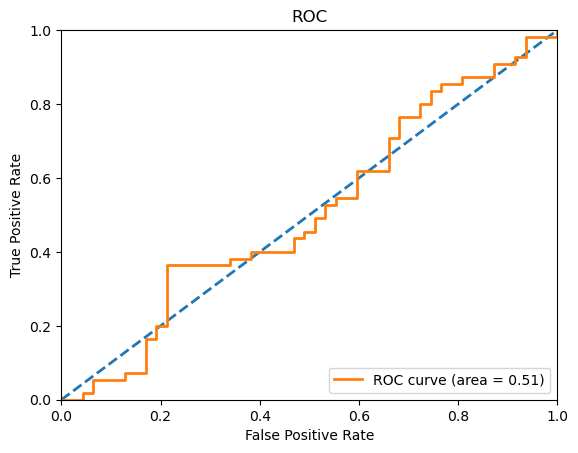

In [38]:
accuracy, roc_auc, test_loss = evaluate_model(model, test_loader, criterion, ROC_curve_graph=True)